# Ames Housing and Kaggle Data Challenge

This project will create a model for evaluating the value of a house based on a number of features provided in the Ames property dataset.

In [1]:
# Import the libraries for the creation of the model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

## Initial Data Exploration

In [2]:
ames = pd.read_csv('../datasets/train.csv')
ames_test = pd.read_csv('../datasets/test.csv')

In [3]:
ames.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


In [4]:
ames.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 81 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               2051 non-null   int64  
 1   PID              2051 non-null   int64  
 2   MS SubClass      2051 non-null   int64  
 3   MS Zoning        2051 non-null   object 
 4   Lot Frontage     1721 non-null   float64
 5   Lot Area         2051 non-null   int64  
 6   Street           2051 non-null   object 
 7   Alley            140 non-null    object 
 8   Lot Shape        2051 non-null   object 
 9   Land Contour     2051 non-null   object 
 10  Utilities        2051 non-null   object 
 11  Lot Config       2051 non-null   object 
 12  Land Slope       2051 non-null   object 
 13  Neighborhood     2051 non-null   object 
 14  Condition 1      2051 non-null   object 
 15  Condition 2      2051 non-null   object 
 16  Bldg Type        2051 non-null   object 
 17  House Style   

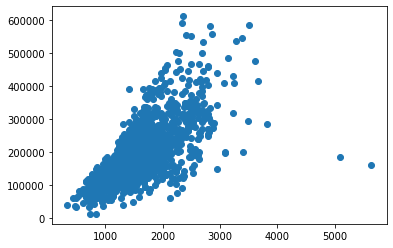

In [5]:
# A quick plot to identify any outliers. The readme document suggests some exist.
plt.scatter(ames['Gr Liv Area'],ames['SalePrice']);

In [6]:
# Remove the two outliers
ames = ames[ames['Gr Liv Area'] < 4000]

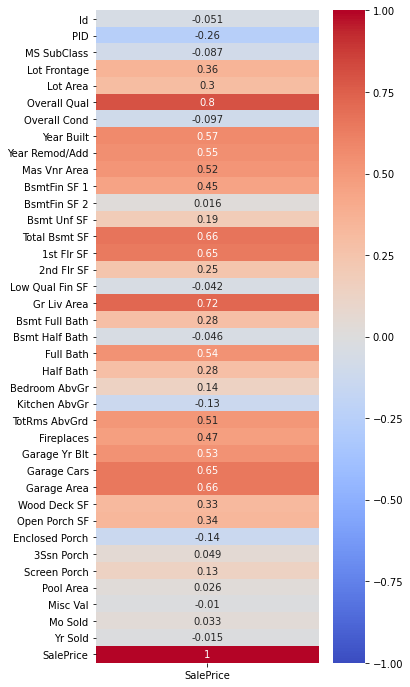

In [7]:
# This heatmap shows which numeric features correlate with the sale price of the property
plt.figure(figsize=(5,12))
sns.heatmap(ames.corr()[['SalePrice']], annot=True, vmin=-1, vmax=1, cmap="coolwarm");

## Data Cleaning

I will make a function to process the data. It will convert textual features, and put reasonable values in places where data is missing. It will output only the features I believe are most significant to keep the data easy to use.

The features included in the model:
- Overall Quality
- Year built
- Year remodeled
- Exter Qual
- Bsmt Qual
- Total Basement Square footage
- 1st floor square footage
- 2nd floor squarefootage
- Above ground living area
- Full bath + basement full bath + half bath count
- Kitchen Quality
- Total rooms above ground
- Number of fireplaces
- Garage Cars
- Garage Area

Additional features will be added for non-numeric data:
- MS Subclass

Many features are in text form but can be converted into a number. An example is exterior quality which is listed from Po for poor, up to Ex for excellent. The features I will convert are:
- Exter Qual (5)
- Exter Cond (5)
- Bsmt Qual (5+NA)
- Bsmt cond (5+NA)
- HeatingQC (5)
- Kitchen qual (5)
- Garage qual (5+NA)
- garage cond (5+NA)


## Feature Engineering

Several features are more significant than other features. Those features will have a second order term to reflect their significance. The process_ames function will add these features to the data.

These features are:
- Overall Quality
- Above Ground Living Area
- Exterior Quality
- Kitchen Quality
- All baths

In [8]:
def process_ames(data):
    
    # I will use a map to reassign numeric values over the text values.
    qual_dict = {'NA':0,
                 'Po':1,
                 'Fa':2,
                 'TA':3,
                 'Gd':4,
                 'Ex':5}
    
    # Here I reassign the data for the above columns.
    data['Exter Qual'] = data['Exter Qual'].map(qual_dict)
    data['Exter Cond'] = data['Exter Cond'].map(qual_dict)
    data['Bsmt Qual'] = data['Bsmt Qual'].map(qual_dict)
    data['Bsmt Cond'] = data['Bsmt Cond'].map(qual_dict)
    data['Heating QC'] = data['Heating QC'].map(qual_dict)
    data['Kitchen Qual'] = data['Kitchen Qual'].map(qual_dict)
    data['Garage Qual'] = data['Garage Qual'].map(qual_dict)
    data['Garage Cond'] = data['Garage Cond'].map(qual_dict)
    
    # Create the all bath feature
    data['All Bath'] = data['Full Bath'] + data['Half Bath'] + data['Bsmt Full Bath']
    
    # Cut down features to just this list:
    my_features = ['Id',
                   'MS SubClass',
                   'Overall Qual',
                   'Year Built',
                   'Year Remod/Add',
                   'Exter Qual',
                   'Bsmt Qual',
                   'Total Bsmt SF',
                   '1st Flr SF',
                   '2nd Flr SF',
                   'Gr Liv Area',
                   'All Bath',
                   'Kitchen Qual',
                   'TotRms AbvGrd',
                   'Fireplaces',
                   'Garage Cars',
                   'Garage Area',
                   'SalePrice']
    
    # This code accounts for the difference between the training and testing data
    try:
        data = data[my_features].copy()
    except:
        my_features.remove('SalePrice')
        data = data[my_features].copy()
        print('No SalePrice found.')

    # This imputes zero for a few houses basement and garage values. Many houses lack these features.
    data.replace(to_replace=np.nan, value=0, inplace=True)
    
    # Create squared features
    data.loc[:,'Overall Qual 2'] = data['Overall Qual']**2
    data.loc[:,'GLA 2'] = data['Gr Liv Area']**2
    data.loc[:,'Exter Qual 2'] = data['Exter Qual']**2
    
    return data

In [9]:
ames_clean = process_ames(ames)

In [10]:
ames_clean.isna().sum()

Id                0
MS SubClass       0
Overall Qual      0
Year Built        0
Year Remod/Add    0
Exter Qual        0
Bsmt Qual         0
Total Bsmt SF     0
1st Flr SF        0
2nd Flr SF        0
Gr Liv Area       0
All Bath          0
Kitchen Qual      0
TotRms AbvGrd     0
Fireplaces        0
Garage Cars       0
Garage Area       0
SalePrice         0
Overall Qual 2    0
GLA 2             0
Exter Qual 2      0
dtype: int64

## Create the Models

Begin with **Linear Regression Model**,

In [11]:
# Create X and y and one-hot encode 
X = ames_clean.drop(columns=['SalePrice','Id'])
X = pd.get_dummies(data=X, columns=['MS SubClass'], drop_first=True)

y = ames_clean['SalePrice']

In [12]:
# Run a cross validtation score to see how we're doing
lr = LinearRegression()
cross_val_score(estimator=lr, X=X, y=y).mean()

0.8878964504350308

In [13]:
# Create train/test splits.
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.7,
    random_state=42
)

In [14]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

LinearRegression()

In [15]:
# Print several metrics to evaluate model
# r2 scores
print(f'Training r2: {model_lr.score(X_train, y_train)}')
print(f'Testing r2:  {model_lr.score(X_test, y_test)}')
y_baseline = [y_test.mean() for _ in range(len(y_test))]
print(f'Baseline r2: {model_lr.score(X_test, y_baseline)}')
print()

# RMSE values
lr_train_RMSE = mean_squared_error(model_lr.predict(X_train), y_train, squared=False)
lr_test_RMSE = mean_squared_error(model_lr.predict(X_test), y_test, squared=False)
lr_base_RMSE = mean_squared_error(y_baseline, y_test, squared=False)
print(f'Training RMSE: {lr_train_RMSE}')
print(f'Testing RMSE:  {lr_test_RMSE}')
print(f'Baseline RMSE: {lr_base_RMSE}')

Training r2: 0.8888953697327634
Testing r2:  0.887361125797735
Baseline r2: 0.0

Training RMSE: 26842.084418131668
Testing RMSE:  26420.663851881538
Baseline RMSE: 78722.62642178997


In [16]:
model_lr.score(X_test, y_test)

0.887361125797735

Next **Ridge Regression Model**: The data will need to be scaled.

In [17]:
# Scale the data
ss = StandardScaler()
ss.fit(X_train)
Z_train = ss.transform(X_train)
Z_test = ss.transform(X_test)

In [18]:
# Do a Gridsearch to evauate best alpha
Rg_params = {'alpha':np.logspace(-5,-1,500)}
grid_Rg = GridSearchCV(estimator=Ridge(), param_grid=Rg_params, cv=5)
grid_Rg.fit(Z_train, y_train);

In [19]:
grid_Rg.best_params_

{'alpha': 0.1}

In [20]:
# Print several metrics to evaluate model
# r2 scores
print(f'Training r2: {grid_Rg.score(Z_train, y_train)}')
print(f'Testing r2:  {grid_Rg.score(Z_test, y_test)}')
print(f'Baseline r2: {grid_Rg.score(Z_test, y_baseline)}')
print()

# RMSE values
Rg_train_RMSE = mean_squared_error(grid_Rg.predict(Z_train), y_train, squared=False)
Rg_test_RMSE = mean_squared_error(grid_Rg.predict(Z_test), y_test, squared=False)
print(f'Training RMSE: {Rg_train_RMSE}')
print(f'Testing RMSE:  {Rg_test_RMSE}')
print(f'Baseline RMSE: {lr_base_RMSE}')

Training r2: 0.8888850961603354
Testing r2:  0.8874974904434481
Baseline r2: 0.0

Training RMSE: 26843.325400272624
Testing RMSE:  26404.666108718662
Baseline RMSE: 78722.62642178997


Next **LASSO Regression Model**:

In [22]:
# Do a Gridsearch to evauate best alpha
Ls_params = {'alpha':np.logspace(1,2,10)}
grid_Ls = GridSearchCV(estimator=Lasso(max_iter=5000), param_grid=Rg_params, cv=5)
grid_Ls.fit(Z_train, y_train);

In [23]:
grid_Ls.best_params_

{'alpha': 0.1}

In [24]:
# Print several metrics to evaluate model
# r2 scores
print(f'Training r2: {grid_Ls.score(Z_train, y_train)}')
print(f'Testing r2:  {grid_Ls.score(Z_test, y_test)}')
print(f'Baseline r2: {grid_Ls.score(Z_test, y_baseline)}')
print()

# RMSE values
Ls_train_RMSE = mean_squared_error(grid_Ls.predict(Z_train), y_train, squared=False)
Ls_test_RMSE = mean_squared_error(grid_Ls.predict(Z_test), y_test, squared=False)
print(f'Training RMSE: {Ls_train_RMSE}')
print(f'Testing RMSE:  {Ls_test_RMSE}')
print(f'Baseline RMSE: {lr_base_RMSE}')

Training r2: 0.8888953673197615
Testing r2:  0.8873624593100089
Baseline r2: 0.0

Training RMSE: 26842.08470961367
Testing RMSE:  26420.507456569263
Baseline RMSE: 78722.62642178997


In [25]:
# Compare the 4 models with the testing data
print(f'Baseline r2: {0.0000}')
print(f'Linear r2:   {model_lr.score(X_test, y_test)}')
print(f'Ridge r2:    {grid_Rg.score(Z_test, y_test)} << Closest to 1')
print(f'Lasso r2:    {grid_Ls.score(Z_test, y_test)}')
print()
print(f'Baseline RMSE: {lr_base_RMSE}')
print(f'Linear RMSE:   {lr_test_RMSE}')
print(f'Ridge   RMSE:  {Rg_test_RMSE}  << Lowest Error')
print(f'LASSO   RMSE:  {Ls_test_RMSE}')


Baseline r2: 0.0
Linear r2:   0.887361125797735
Ridge r2:    0.8874974904434481 << Closest to 1
Lasso r2:    0.8873624593100089

Baseline RMSE: 78722.62642178997
Linear RMSE:   26420.663851881538
Ridge   RMSE:  26404.666108718662  << Lowest Error
LASSO   RMSE:  26420.507456569263


Each of the three models outperformed the baseline by a large margine. The linear model performed very similarly to the ridge and lasso models which suggests the model is not overfit and only benefits slightly from the regularization. The ridge model performs the best here, however it doen't do as well as the linear model in the Kaggle competition. The fireplace information also doesn't improve the result for the competition.

## Clean Testing Data

The testing data is in a similar format to the training data but doen't include the sale price. The processing function has a feature to account for the different formatting.

In [26]:
# Clean ames testing data
ames_test_clean = process_ames(ames_test)

No SalePrice found.


In [27]:
X_ames_test = pd.get_dummies(data=ames_test_clean.drop(columns='Id'), 
                             columns=['MS SubClass'], 
                             drop_first=True)

In [28]:
# There are no MS SubClass_150 properties in the testing data so I need to toss in a column of zeros
X_ames_test['MS SubClass_150'] = [0 for _ in range(len(X_ames_test))]

In [29]:
# Scale the matrix for ridge model
Z_ames_test = ss.transform(X_ames_test)

In [30]:
submission = grid_Rg.predict(Z_ames_test)

In [31]:
# Columns must be formatted appropriatly or the submission will fail.
submission = pd.DataFrame(submission, columns = ['SalePrice'])
submission['Id'] = ames_test_clean['Id']
submission = submission[['Id','SalePrice']]
submission.head()

,Id,SalePrice
0,2658,125644.701282
1,2718,193402.743445
2,2414,207518.113140
3,1989,109743.924934
4,625,189063.299870


In [32]:
# Write the submission data to a file. Change filename or the data will overwrite!
# This code is commented out unless the output is explicitly needed

#submission.to_csv('./kaggle_sub/submission_6.csv', index=False)

## Explore Fireplace related data

Data Science question: Is a fireplace a good investment in the value of your property?

In [33]:
# I create a new DataFrame to keep the original unaltered
ames_fire = ames

In [34]:
# Create a column mapping fireplace count to colors
fcolors =  {0:'black', 1:'red', 2:'orange', 3:'yellow', 4:'blue'}
ames_fire['fcolor'] = ames_fire['Fireplaces'].map(fcolors)

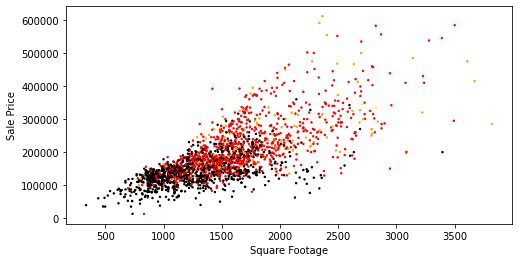

In [35]:
# I didin't use this figure, but I really like how it looks
plt.figure(figsize=(8,4))

plt.scatter(ames_fire['Gr Liv Area'], ames_fire['SalePrice'], color=ames_fire['fcolor'], s=2)
plt.xlabel('Square Footage')
plt.ylabel('Sale Price');

This figure shows house square footage vs sale price. The color of the dot relates to the quantity of fireplaces. Black is 0 fireplaces, then red, orange yellow and blue in increasing number of fireplaces. The figure has more fireplaces in the top right where there are larger and more expensive houses.

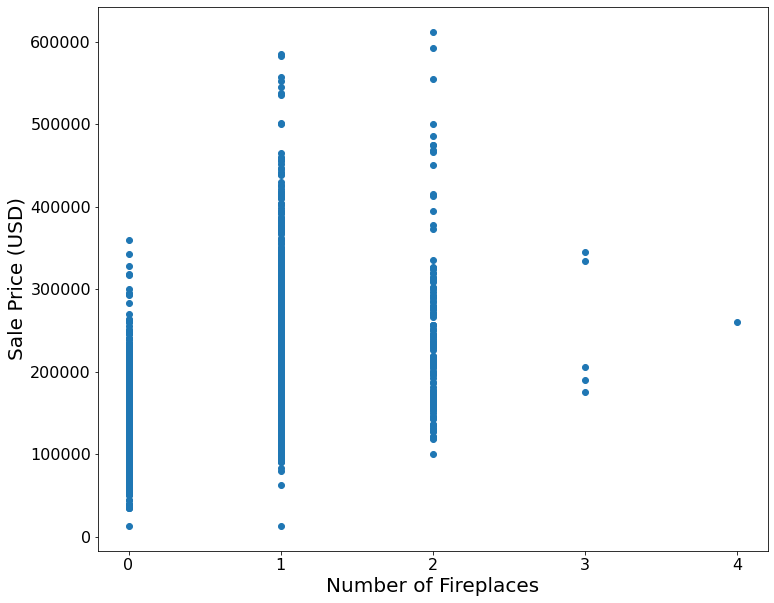

In [36]:
# Create figure of Fireplaces vs Sale Price
plt.figure(figsize=(12,10))
plt.scatter(ames_fire['Fireplaces'], ames_fire['SalePrice']);
plt.ylabel('Sale Price (USD)', size = 20)
plt.xlabel('Number of Fireplaces', size = 20)
#plt.title('Number of Fireplaces vs Sale Price', size = 24)
plt.yticks(size=16)
plt.xticks(range(5), size=16);

# Output the figure as an image file.
plt.savefig("../images/fireplace_vs_saleprice.png")

This figure shows number of fireplaces vs sale price. The correlation isn't entirely clear but a vague positive slope does exist. There is one crazy house from the 70's that has 4 fireplaces. I like that the figure has a big gap between 0 and 1 fireplaces at high sale price.

In [37]:
# Here I convert a text column into a numeric column similar to the processing function.
qual_dict = {'NA':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5}
ames_fire['Fireplace Qu'] = ames_fire['Fireplace Qu'].map(qual_dict)

In [38]:
# Here I create a column called isFire. I identify houses with fireplaces 
# that more closely fit my descriptions of fireplaces in the presentation.
ames_fire['isFire'] = (ames_fire['Fireplace Qu'] > 2).astype(int)

In [39]:
# This crates a table that shows the mean sale price of several catagories
ames_fire.groupby(by=['Bedroom AbvGr','isFire'])['SalePrice'].mean()

Bedroom AbvGr  isFire
0              0         177653.000000
               1         335500.000000
1              0         108645.555556
               1         250459.717949
2              0         128852.533923
               1         224060.450980
3              0         154147.189003
               1         210021.704762
4              0         142102.207921
               1         260499.981707
5              0         141316.666667
               1         252853.217391
6              0         143033.600000
               1         269500.000000
8              0         200000.000000
Name: SalePrice, dtype: float64

In [40]:
# This Extracts the info from the above table
bar_sm = list(ames_fire[ames_fire['isFire'] == 0].groupby(by='Bedroom AbvGr')['SalePrice'].mean())
bar_big = list(ames_fire[ames_fire['isFire'] == 1].groupby(by='Bedroom AbvGr')['SalePrice'].mean())
bar_big

[335500.0,
 250459.71794871794,
 224060.45098039217,
 210021.70476190475,
 260499.98170731709,
 252853.21739130435,
 269500.0]

In [41]:
bar_sm[:-2]

[177653.0,
 108645.55555555556,
 128852.53392330384,
 154147.18900343642,
 142102.20792079208,
 141316.66666666666]

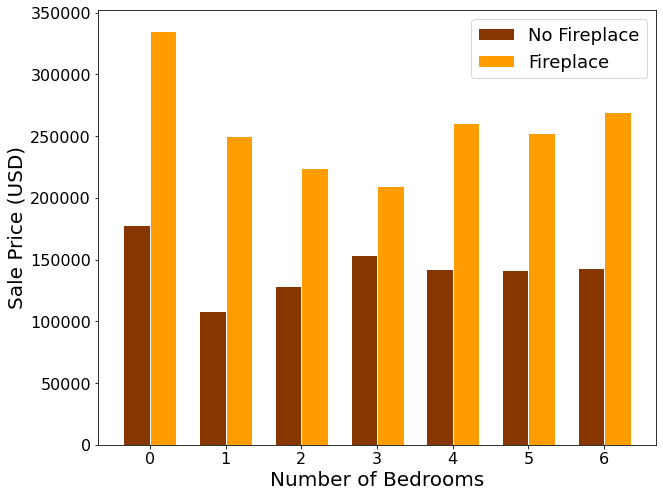

In [42]:
# Creat a very good looking bar plot of bedrooms and fireplaces vs price

# Graph style shamelessly stolen from:
# https://python-graph-gallery.com/11-grouped-barplot/

# set width of bar
barWidth = 0.35

# List for labelling the plot
firelabel =['No Fireplace', 'Fireplace']
 
# set height of bar
# We need to remove one 7 room house because of lack of data 
sm = bar_sm[:-1]
big = bar_big
 
# Set position of bar on X axis
rbig = [x + barWidth*1.5 for x in range(7)]
rsm = [x + barWidth*0.5 for x in range(7)]
 
# Make the plot
plt.figure(figsize=(10,8))
plt.bar(rsm, sm, color='#873600', width=barWidth, edgecolor='white', label='No Fireplace')
plt.bar(rbig, big, color='#ff9d00', width=barWidth, edgecolor='white', label='Fireplace')
 
# Add xticks on the middle of the group bars
plt.xlabel('Number of Bedrooms', size=20)
plt.ylabel('Sale Price (USD)', size=20)
plt.xticks([r + barWidth for r in range(7)], ['0', '1', '2', '3', '4', '5', '6'], size=16)
plt.yticks(size=16)
 
# Create legend & Show graphic
plt.legend(fontsize=18)

# Output the figure as an image file.
plt.savefig("../images/price_vs_bedrooms.png")
plt.show()

In [48]:
# List all of the model coefficients for the linear model with the column name.
list(zip(X_train.columns,model_lr.coef_))[12]

('Fireplaces', 10296.05146495962)

Fireplace coefficient is 10296. This means that adding a fireplace increases the predicted sale price by over 10k USD.